### Import packages

In [1]:
import cantera as ct
import numpy as np
from scipy.integrate import solve_ivp
%matplotlib inline
import matplotlib.pyplot as plt

print(f"Cantera Version: {ct.__version__}")

# This Example Requires: cantera >= 2.6.0, matplotlib >= 2.0

Cantera Version: 2.6.0


# Make your own: Accelerating Wall Reactor

Here we will solve an ignition problem where the normal reactor governing equations are
extended with additional equations implemented in Python.
This demonstrates an approach for solving problems where Cantera's built-in
reactor models are not sufficient for describing the system in question. Unlike
the 'custom.py' example, in this example Cantera's existing Reactor and
ReactorNet code is still used, with only the modifications to the standard
equations implemented in Python by extending the ExtensibleReactor class.
Wall objects in Cantera are normally massless, with the velocity either imposed
or proportional to the pressure difference. Here, we simulate a wall where the
acceleration is proportional to the pressure difference, and the velocity is
determined by integrating the equation of motion. This requires adding a new
variable to the reactor's state vector which represents the wall velocity.

### Unmodified Perfectly Stirred Reactor
The perfectly stirred reactor (aka "PSR") is defined by a relatively simple set of governing equations, providing an excellent opportunity to demonstrate how we can use Cantera as a "calculator" to provide the terms and variables required for solving a set of equations of our own choosing.

<img src="PSR.png" alt="Cartoon of a Perfectly Stirred Chemical Reactor." style="width: 500px;"/>

The model includes user inputs for the inlet gas conditions (temperature, pressure, composition) and mass flux (typically defined in terms of the residence time $\tau$), some condition for the outlet flow, and an optional heat transfer boundary condition.

## Differential equations:

An Ideal Gas Reactor is defined by the four state variables: 

- m, the mass of the reactor's contents (in kg)

- V, the reactor volume (in m^3)

- T, the temperature (in K)

- Y_k, the mass fractions for each species (dimensionless)

The total mass of the reactor's contents changes as a result of flow through
the reactor's inlets and outlets, and production of homogeneous phase species
on the reactor walls:


1) 

$\frac{dm}{dt} = \sum_{in} \dot{m}_{in} - \sum_{out} \dot{m}_{out} +\dot{m}_{wall}$

Where the subscripts *in* and *out* refer to the sum of the superscipted property
over all inlets and outlets respectively. A dot above a variable signifies a time 
derivative.

The reactor volume changes as a function of time due to the motion of one or
more walls:

2) 

$\frac{dV}{dt} = \sum_w f_w A_w v_w(t)$

Where $f_w = \pm 1$ indicates the facing of the wall (whether moving the wall increases or
decreases the volume of the reactor), $A_w$ is the
surface area of the wall, and $v_w(t)$ is the velocity of the wall as a
function of time.

In case of the Ideal Gas Reactor Model, the reactor temperature $T$ is
used instead of the total internal energy $U$ as a state variable. For an
ideal gas, we can rewrite the total internal energy in terms of the mass
fractions and temperature:

   $U = m \sum_k Y_k u_k(T)$

   $\frac{dU}{dt} = u \frac{dm}{dt} + m c_v \frac{dT}{dt}+ m \sum_k u_k \frac{dY_k}{dt}$

Substituting the corresponding derivatives yields an equation for the
temperature:

3)  

$m c_v \frac{dT}{dt} = - p \frac{dV}{dt} + \dot{Q}+ \sum_{in} \dot{m}_{in} \left( h_{in} - \sum_k u_k Y_{k,in} \right)- \frac{p V}{m} \sum_{out} \dot{m}_{out} - \sum_k \dot{m}_{k,gen} u_k$

While this form of the energy equation is somewhat more complicated, it
significantly reduces the cost of evaluating the system Jacobian, since the
derivatives of the species equations are taken at constant temperature instead
of constant internal energy.

The rate at which species k is generated through homogeneous phase
reactions is $V \dot{\omega}_k W_k$, and the total rate at which species
k is generated is:

   $\dot{m}_{k,gen} = V \dot{\omega}_k W_k + \dot{m}_{k,wall}$

The rate of change in the mass of each species is:

  $\frac{d(mY_k)}{dt} = \sum_{in} \dot{m}_{in} Y_{k,in} - \sum_{out} \dot{m}_{out} Y_k + \dot{m}_{k,gen}$

Expanding the derivative on the left hand side and substituting the equation
for $dm/dt$, the equation for each homogeneous phase species is:

4) 

$m \frac{dY_k}{dt} = \sum_{in} \dot{m}_{in} (Y_{k,in} - Y_k)+\dot{m}_{k,gen} - Y_k \dot{m}_{wall} $

Equations 1-4 are the governing equations for an Ideal Gas Reactor.

### Creating a New Reactor Class Type:

#### Inside Cantera:

#### Example:

In [2]:
class InertialWallReactor(ct.ExtensibleIdealGasReactor):
    def __init__(self, *args, neighbor, **kwargs):
        super().__init__(*args, **kwargs)
        self.v_wall = 0  # initial wall velocity
        self.k_wall = 1e-2  # proportionality constant, a_wall = k_wall * delta P
        self.neighbor = neighbor

    def after_initialize(self, t0):
        # The initialize function for the base Reactor class will have set
        # n_vars to already include the volume, internal energy, mass, and mass
        # fractions of all the species. Increase this by one to account for
        # the added variable of the wall velocity.
        self.n_vars += 1

        # The index for the new variable / equation, which is at the end of the
        # state vector
        self.i_wall = self.n_vars - 1

    def after_get_state(self, y):
        # This method is used to set the initial condition used by the ODE solver
        y[self.i_wall] = self.v_wall

    def after_update_state(self, y):
        # This method is used to set the state of the Reactor and Wall objects
        # based on the new values for the state vector provided by the ODE solver
        self.v_wall = y[self.i_wall]
        self.walls[0].set_velocity(self.v_wall)

    def after_eval(self, t, LHS, RHS):
        # Calculate the time derivative for the additional equation
        a = self.k_wall * (self.thermo.P - self.neighbor.thermo.P)
        RHS[self.i_wall] = a

    def before_component_index(self, name):
        # Other components are handled by the method from the base Reactor class
        if name == 'v_wall':
            return self.i_wall

    def before_component_name(self, i):
        # Other components are handled by the method from the base Reactor class
        if i == self.i_wall:
            return 'v_wall'


### Instantiate Cantera objects:

In [3]:
gas = ct.Solution('h2o2.yaml')

# Initial condition
P = ct.one_atm
gas.TPY = 920, P, 'H2:1.0, O2:1.0, N2:3.76'

# Set up the reactor network
res = ct.Reservoir(gas)
r = InertialWallReactor(gas, neighbor=res)
w = ct.Wall(r, res)
net = ct.ReactorNet([r])

### Initialize the Solution Vector and compute solution:

In [4]:
# Integrate the equations, keeping T(t) and Y(k,t)
states = ct.SolutionArray(gas, 1, extra={'t': [0.0], 'V': [r.volume]})
while net.time < 0.5:
    net.advance(net.time + 0.005)
    states.append(TPY=r.thermo.TPY, V=r.volume, t=net.time)

### Some basic plotting:

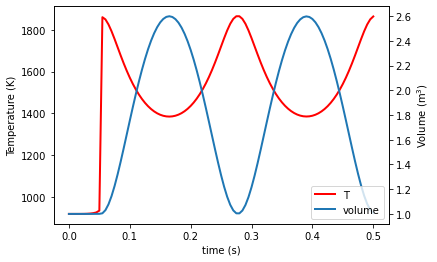

In [5]:
try:
    import matplotlib.pyplot as plt
    L1 = plt.plot(states.t, states.T, color='r', label='T', lw=2)
    plt.xlabel('time (s)')
    plt.ylabel('Temperature (K)')
    plt.twinx()
    L2 = plt.plot(states.t, states.V, label='volume', lw=2)
    plt.ylabel('Volume (m$^3$)')
    plt.legend(L1+L2, [line.get_label() for line in L1+L2], loc='lower right')
    plt.show()
except ImportError:
    print('Matplotlib not found. Unable to plot results.')